In [1]:
using Pkg
Pkg.activate(".")
# Pkg.instantiate()

  Activating project at `~/Physics/QInchworm/QInchworm.git/experiments/anderson`


In [2]:
using LinearAlgebra, Printf
using PyPlot
using Keldysh

In [3]:
@enum SpinEnum spin_up = UInt8(1) spin_down=UInt8(2)
Base.to_index(A, sp::SpinEnum) = Int(sp)
flip(sp::SpinEnum) = sp == spin_up ? spin_down : spin_up

# type representing state of anderson impurity
# occupation of up/down stored in first two bits
struct FockState
    state::UInt8
    function FockState(s)
        @assert s < 4
        new(s)
    end
end

# check whether ith spin is occupied
# note sp ∈ [1, 2] so don't need to do (1 << (sp - 1))
Base.getindex(st::FockState, sp::SpinEnum) = (st.state & UInt8(sp)) > 0

# flip occupation of ith spin
# note sp ∈ [1, 2] so don't need to do (sp << (i - 1))
flip(st::FockState, sp::SpinEnum) = FockState(st.state ⊻ UInt8(sp))

# convert internal state to index
Base.to_index(st::FockState) = Int(st.state + 1)

In [4]:
struct NCAParams
  dyson_rtol::Float64
  dyson_atol::Float64
  dyson_max_iter::Int
  max_order::Int
  function NCAParams(dyson_rtol, dyson_atol, dyson_max_iter, max_order)
    @assert 1 <= max_order <= 2
    new(dyson_rtol, dyson_atol, dyson_max_iter, max_order)
  end
end
NCAParams(; dyson_rtol = 1e-6, dyson_atol = 1e-10, dyson_max_iter = 100, max_order = 1) = NCAParams(dyson_rtol, dyson_atol, dyson_max_iter, max_order)

struct NCAData{T <: AbstractTimeGF, U <: AbstractTimeGrid}
  P0::Array{T,1} # bare propagator
  Δ::Array{T, 1} # hybridization function

  P::Array{T,1} # dressed propagator
  Σ::Array{T,1} # self-energy
  ΣxP::Array{T,1} # self-energy convolved with propagator
  G::Array{T,1} # green's function

  grid::U # time grid
  states::NTuple{4, FockState}
  spins::Tuple{SpinEnum, SpinEnum}
end

function NCAData(P0, Δ)
  states = ntuple(i -> FockState(i-1), 4)
  spins = instances(SpinEnum)

  statesize = length(states)
  indexsize = length(spins)

  @assert length(P0) == statesize
  @assert length(Δ) == indexsize

  grid = first(P0).grid

  X = P0[1]
  P = [zero(X) for _ in 1:statesize]
  Σ = [zero(X) for _ in 1:statesize]
  ΣxP = [zero(X) for _ in 1:statesize]
  G = [zero(X) for _ in 1:indexsize]

  NCAData(P0, Δ, P, Σ, ΣxP, G, grid, states, spins)
end

NCAData

In [5]:
function Σnca(data::NCAData, t1::TimeGridPoint, t2::TimeGridPoint, st_sigma::FockState)
  sum(data.spins) do sp
    st_prop = flip(st_sigma, sp)
    1.0im * data.P[st_prop][t1, t2] * (st_sigma[sp] ? data.Δ[sp][t1, t2] : -data.Δ[sp][t2, t1, false])
  end
end

Σnca (generic function with 1 method)

In [6]:
function dyson!(data::NCAData, t1::TimeGridPoint, t2::TimeGridPoint, params::NCAParams)
  @assert t1.cidx >= t2.cidx

  p_t1t2_cur = zeros(ComplexF64, length(data.states))
  p_t1t2_next = zeros(ComplexF64, length(data.states))

  for st in data.states
    p_t1t2_cur[st] = data.P0[st][t1,t2]
    data.P[st][t1,t2] = data.P0[st][t1,t2] # initial guess
  end

  ↻ = (A, B) -> integrate(t -> @inbounds(A[t1, t] * B[t, t2]), data.grid, t1, t2)

  done = false
  iter = 1
  diff = 0.0
  while iter <= params.dyson_max_iter && !done

    for st in data.states
      p_t1t2_next[st] = 0.0

      data.Σ[st][t1, t2] = 0.0
      params.max_order > 0 && (data.Σ[st][t1, t2] += Σnca(data, t1, t2, st))
      params.max_order > 1 && (data.Σ[st][t1, t2] += Σoca(data, t1, t2, st))

      # p = p₀ + p₀ ↻ Σ ↻ p
      data.ΣxP[st][t1, t2] = data.Σ[st] ↻ data.P[st]
      p_t1t2_next[st] += data.P0[st] ↻ data.ΣxP[st]

      p_t1t2_next[st] += data.P0[st][t1, t2]
    end

    diff = norm(p_t1t2_cur - p_t1t2_next)
    done = diff < max(params.dyson_atol, params.dyson_rtol * norm(p_t1t2_cur))
    for st in data.states
      data.P[st][t1,t2] = p_t1t2_next[st]
    end
    p_t1t2_cur .= p_t1t2_next
    iter += 1
  end
end

function nca!(data::NCAData, params::NCAParams)
  N = length(data.grid)
  for d in 0:(N-1) # solve diagonal by diagonal
#     println("diagonal $(d+1)/$N")
    for j in 1:(N-d)
      i = j + d
      t1 = data.grid[i]
      t2 = data.grid[j]
      dyson!(data, t1, t2, params)
    end
  end

  return data
end

nca! (generic function with 1 method)

In [7]:
struct SplitPropagator
  P::GenericTimeGF{ComplexF64,true}
  P0::GenericTimeGF{ComplexF64,true}
  t_split::TimeGridPoint
end

function Base.getindex(P::SplitPropagator, t1::TimeGridPoint, t2::TimeGridPoint)
  @assert t1.cidx >= t2.cidx
  t_split = P.t_split
  
  if t1.cidx <= t_split.cidx
    return P.P[t1, t2]
  elseif t1.cidx > t_split.cidx && t2.cidx < t_split.cidx
    return im * P.P0[t1, t_split] * P.P[t_split, t2]
  elseif t2.cidx >= t_split.cidx
    return P.P0[t1, t2]
  else
    error("unreachable")
  end
end

struct InchParams
  max_order::Int
end
InchParams(; max_order = 1) = InchParams(max_order)

struct InchData{T <: AbstractTimeGF, U <: AbstractTimeGrid}
  P0::Array{T,1} # bare propagator
  P::Array{T,1} # dressed propagator
  Δ::Array{T, 1} # hybridization function
  G::Array{T,1} # green's function

  grid::U # time grid
  states::NTuple{4, FockState}
  spins::Tuple{SpinEnum, SpinEnum}
end


function InchData(P0, Δ)
  states = ntuple(i -> FockState(i-1), 4)
  spins = instances(SpinEnum)

  statesize = length(states)
  indexsize = length(spins)

  @assert length(P0) == statesize
  @assert length(Δ) == indexsize

  grid = first(P0).grid

  X = P0[1]
  P = [zero(X) for _ in 1:statesize]
  G = [zero(X) for _ in 1:indexsize]

  InchData(P0, P, Δ, G, grid, states, spins)
end

function inch_order0(data::InchData, t1::TimeGridPoint, t2::TimeGridPoint, st::FockState)
  @assert t1.cidx >= t2.cidx
  
  if t1.cidx == t2.cidx
    return data.P0[st][t1, t2]
  end
  
  P0, P, Δ, grid = data.P0, data.P, data.Δ, data.grid
  
  t_split = grid[t1.cidx - 1]
  P_split = [SplitPropagator(P[s], P0[s], t_split) for s in 1:4]
  return P_split[st][t1, t2]
end

function inch_order1(data::InchData, t1::TimeGridPoint, t4::TimeGridPoint, st::FockState)
  @assert t1.cidx >= t4.cidx
  
  if t1.cidx == t4.cidx
    return 0.0im
  end
  
  P0, P, Δ, grid = data.P0, data.P, data.Δ, data.grid
  
  grid = P[1].grid
  
  t_split = grid[t1.cidx - 1]
  P_split = [SplitPropagator(P[s], P0[s], t_split) for s in 1:4]
  
  sum(data.spins) do sp
    s0 = st
    s1 = flip(st, sp)
    s2 = st
    
    hyb = (t2, t3) -> st[sp] ? Δ[sp][t2, t3] : -Δ[sp][t3, t2, false]
    loc = (t2, t3) -> im * P_split[s2][t1, t2] * P_split[s1][t2, t3] * P_split[s0][t3, t4]
    
    f = t2 -> integrate(t3 -> hyb(t2, t3) * loc(t2, t3), grid, t2, t4)
    return integrate(f, grid, t1, t_split)
  end
end

function inch!(data::InchData, t1::TimeGridPoint, t2::TimeGridPoint, params::InchParams)
  for st in data.states
    x = inch_order0(data, t1, t2, st)
    params.max_order > 0 && (x += inch_order1(data, t1, t2, st))
    data.P[st][t1,t2] = x
  end
end


function inch!(data::InchData, params::InchParams)
  N = length(data.grid)
  for d in 0:(N-1) # solve diagonal by diagonal
    for j in 1:(N-d)
      i = j + d
      t1 = data.grid[i]
      t2 = data.grid[j]
      inch!(data, t1, t2, params)
    end
  end

  return data
end

inch! (generic function with 2 methods)

In [8]:
function make_bare_prop(grid::KeldyshTimeGrid, ρ, ϵ, U)
  E = [0.0, ϵ, ϵ, 2*ϵ + U]
  ξ = [1.0, -1.0, -1.0, 1.0]
  P = map(1:4) do s
    GenericTimeGF(grid, 1, true) do t1, t2
      t1.cidx < t2.cidx && return 0.0
      ϕ = integrate(t -> E[s], grid, t1, t2)
      heaviside(t1.bpoint, t2.bpoint) ? -im * exp(-im * ϕ) : -im * ξ[s] * ρ[s] * exp(-im * ϕ)
    end
  end
  return P
end

function make_bare_prop(grid::FullTimeGrid, ϵ, U)
  E = [0.0, ϵ, ϵ, 2*ϵ + U]
  ξ = [1.0, -1.0, -1.0, 1.0]
  P = map(1:4) do s
    GenericTimeGF(grid, 1, true) do t1, t2
      t1.cidx < t2.cidx && return 0.0
      ϕ = integrate(t -> E[s], grid, t1, t2)
      heaviside(t1.bpoint, t2.bpoint) ? -im * exp(-im * ϕ) : -im * ξ[s] * exp(-im * ϕ)
    end
  end
  return P
end

make_bare_prop (generic function with 2 methods)

In [9]:
"""
Compute the populations (i.e. the diagonal components of the impurity density matrix) from a propagator
"""
function populations(P)
  nstates = length(P)
  ξ = [1.0, -1.0, -1.0, 1.0]
  P_lsr_diag = reduce(hcat, (1.0im * ξ[s] * diag(P[s][:lesser]) for s in 1:nstates))
  Zt = sum(P_lsr_diag, dims=2)
  ρt = P_lsr_diag ./ Zt
  return ρt, Zt
end

populations

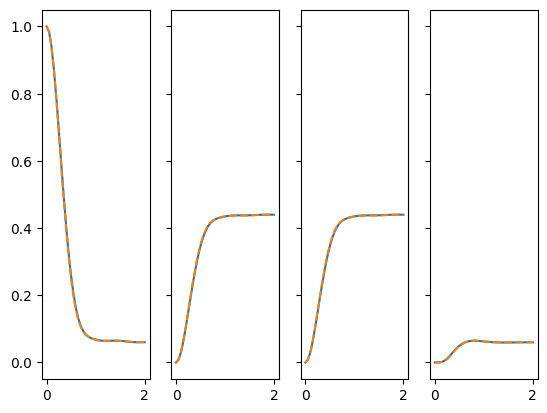

In [10]:
function run_inch_keldysh()
  tmax = 2.0
  β = 2.0
  nt = 41
  
  c = twist(KeldyshContour(; tmax))
  grid = KeldyshTimeGrid(c, nt)
  
  ρ = [1.0, 0.0, 0.0, 0.0]
  ϵ = -4.0
  U = 8.0
  P0 = make_bare_prop(grid, ρ, ϵ, U)
  
  dos = flat_dos(;D=10.0, ν=10.0)
  Δ = [GenericTimeGF(dos, β, grid) for s in 1:2]
  
  nca_params = NCAParams(max_order = 1)
  nca_data = NCAData(P0, Δ)
  nca!(nca_data, nca_params)
  
  inch_params = InchParams(max_order = 1)
  inch_data = InchData(P0, Δ)
  inch!(inch_data, inch_params)
  
  t = collect(realtimes(grid))
  
  ρt_nca, Zt_nca = populations(nca_data.P)
  ρt_inch, Zt_inch = populations(inch_data.P)
  
  fig, axes = plt.subplots(ncols=4, sharey=true)
  
  for s in 1:4
    axes[s].plot(t, real(ρt_nca[:,s]))
    axes[s].plot(t, real(ρt_inch[:,s]), "--")
  end

end

run_inch_keldysh()

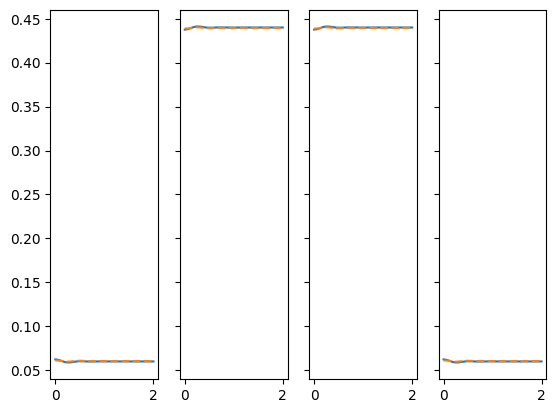

In [11]:
function run_inch_full()
  tmax = 2.0
  β = 2.0
  nt = 41
  nτ = 41
  
  c = twist(FullContour(; tmax, β))
  grid = FullTimeGrid(c, nt, nτ)
  
  ϵ = -4.0
  U = 8.0
  P0 = make_bare_prop(grid, ϵ, U)
  
  dos = flat_dos(;D=10.0, ν=10.0)
  Δ = [GenericTimeGF(dos, grid) for s in 1:2]
  
  nca_params = NCAParams(max_order = 1)
  nca_data = NCAData(P0, Δ)
  nca!(nca_data, nca_params)
  
  inch_params = InchParams(max_order = 1)
  inch_data = InchData(P0, Δ)
  inch!(inch_data, inch_params)
  
  t = collect(realtimes(grid))
  
  ρt_nca, Zt_nca = populations(nca_data.P)
  ρt_inch, Zt_inch = populations(inch_data.P)
  
  fig, axes = plt.subplots(ncols=4, sharey=true)
  
  for s in 1:4
    axes[s].plot(t, real(ρt_nca[:,s]))
    axes[s].plot(t, real(ρt_inch[:,s]), "--")
  end

end

run_inch_full()